In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [3]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [4]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [5]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [6]:
from torch import nn

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0,max_val=1,inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = self.relu(out)
        else:
            out = self.relu(out)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 80, start_factor=1.0, end_factor=0.01, total_iters=70):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.0025, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.96)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                regularization_loss = 0
                for param in self.parameters():
                    regularization_loss += torch.sum(torch.abs(param))
                loss = criterion(outputs, labels) + 0.0001*regularization_loss
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_CIFAR10-DVS_ReLU_ReLU1_ReLUmaxpool_EST_FC2__128x128_pretrained_aug_correct_trilinear_mixed_L1_L2.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [8]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")


In [9]:
model_resnet

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): Hardtanh(min_val=0, max_val=1)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchN

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
print(model)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.4659e-02, -3.5008e-02,  4.4316e-02,  ..., -3.3112e-02,
           -4.4417e-02, -1.6130e-02],
          [-5.6375e-02,  4.0862e-02,  5.3885e-02,  ..., -2.3953e-02,
           -5.5273e-02, -4.7928e-02],
          [-1.3983e-03, -4.8295e-02,  9.5565e-03,  ...,  2.6728e-02,
           -8.1077e-03, -2.6087e-02],
          ...,
          [-4.5045e-02, -1.1257e-02,  4.8147e-02,  ...,  5.1294e-02,
            5.6206e-02, -1.5439e-02],
          [-3.2292e-02, -4.9721e-02, -3.6644e-03,  ...,  4.8476e-02,
           -3.5749e-03,  1.7028e-03],
          [-3.3013e-02, -3.5309e-02, -5.7898e-02,  ...,  1.8287e-02,
           -3.8847e-02, -6.9663e-05]],

         [[ 2.4394e-02,  1.2227e-02, -2.1161e-03,  ..., -4.4165e-02,
           -5.3659e-02, -4.0429e-02],
          [-8.3277e-03, -6.7814e-03,  1.1696e-02,  ...,  9.9629e-03,
            4.8550e-02,  1.2104e-02],
          [ 1.2422e-02, -1.6917e-02, -2.9917e-02,  ...,  2.8131e-02,
            2.4650e-02,  1.4722e-02]

### Copy of a weights

In [12]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): Hardtanh(min_val=0, max_val=1)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=F

In [13]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.8192e-01]

In [14]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.4659e-02, -3.5008e-02,  4.4316e-02,  ..., -3.3112e-02,
           -4.4417e-02, -1.6130e-02],
          [-5.6375e-02,  4.0862e-02,  5.3885e-02,  ..., -2.3953e-02,
           -5.5273e-02, -4.7928e-02],
          [-1.3983e-03, -4.8295e-02,  9.5565e-03,  ...,  2.6728e-02,
           -8.1077e-03, -2.6087e-02],
          ...,
          [-4.5045e-02, -1.1257e-02,  4.8147e-02,  ...,  5.1294e-02,
            5.6206e-02, -1.5439e-02],
          [-3.2292e-02, -4.9721e-02, -3.6644e-03,  ...,  4.8476e-02,
           -3.5749e-03,  1.7028e-03],
          [-3.3013e-02, -3.5309e-02, -5.7898e-02,  ...,  1.8287e-02,
           -3.8847e-02, -6.9663e-05]],

         [[ 2.4394e-02,  1.2227e-02, -2.1161e-03,  ..., -4.4165e-02,
           -5.3659e-02, -4.0429e-02],
          [-8.3277e-03, -6.7814e-03,  1.1696e-02,  ...,  9.9629e-03,
            4.8550e-02,  1.2104e-02],
          [ 1.2422e-02, -1.6917e-02, -2.9917e-02,  ...,  2.8131e-02,
            2.4650e-02,  1.4722e-02]

In [ ]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=300,save_best=True, save_thr=48) #, learning_rate=5e-4

100%|██████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch [1/300], Step [219/219], Loss: 26.8313, Accuracy: 0.1100
Accuracy of the network: 11.6 Loss: 2.2944812901476594%


100%|██████████| 219/219 [00:55<00:00,  3.96it/s]


Epoch [2/300], Step [219/219], Loss: 5.8524, Accuracy: 0.1541
Accuracy of the network: 19.066666666666666 Loss: 2.1298208249376174%


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


Epoch [3/300], Step [219/219], Loss: 5.1343, Accuracy: 0.1756
Accuracy of the network: 17.066666666666666 Loss: 2.0873524965123926%


100%|██████████| 219/219 [00:56<00:00,  3.89it/s]


Epoch [4/300], Step [219/219], Loss: 4.7634, Accuracy: 0.2031
Accuracy of the network: 19.966666666666665 Loss: 2.1144409433324287%


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


Epoch [5/300], Step [219/219], Loss: 4.5991, Accuracy: 0.2120
Accuracy of the network: 20.6 Loss: 2.0905047452196164%


100%|██████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch [6/300], Step [219/219], Loss: 4.5604, Accuracy: 0.2191
Accuracy of the network: 22.1 Loss: 2.053651681605806%


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [7/300], Step [219/219], Loss: 4.4276, Accuracy: 0.2306
Accuracy of the network: 21.566666666666666 Loss: 2.019260291089403%


100%|██████████| 219/219 [00:54<00:00,  4.02it/s]


Epoch [8/300], Step [219/219], Loss: 4.3125, Accuracy: 0.2360
Accuracy of the network: 22.433333333333334 Loss: 2.053870237888174%


100%|██████████| 219/219 [00:54<00:00,  4.02it/s]


Epoch [9/300], Step [219/219], Loss: 4.1942, Accuracy: 0.2447
Accuracy of the network: 22.433333333333334 Loss: 2.0253494775041623%


100%|██████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch [10/300], Step [219/219], Loss: 4.1419, Accuracy: 0.2421
Accuracy of the network: 24.933333333333334 Loss: 1.9862115319738998%


100%|██████████| 219/219 [00:54<00:00,  4.02it/s]


Epoch [11/300], Step [219/219], Loss: 4.0188, Accuracy: 0.2470
Accuracy of the network: 25.233333333333334 Loss: 1.9823819792017023%


100%|██████████| 219/219 [00:54<00:00,  4.02it/s]


Epoch [12/300], Step [219/219], Loss: 3.9801, Accuracy: 0.2461
Accuracy of the network: 24.9 Loss: 1.967585841391949%


100%|██████████| 219/219 [00:54<00:00,  4.02it/s]


Epoch [13/300], Step [219/219], Loss: 3.8468, Accuracy: 0.2531
Accuracy of the network: 25.466666666666665 Loss: 1.958128570242131%


100%|██████████| 219/219 [00:54<00:00,  4.02it/s]


Epoch [14/300], Step [219/219], Loss: 3.7823, Accuracy: 0.2596
Accuracy of the network: 25.5 Loss: 2.0263370300861117%


100%|██████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch [15/300], Step [219/219], Loss: 3.6847, Accuracy: 0.2739
Accuracy of the network: 25.9 Loss: 1.9686351963814268%


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [16/300], Step [219/219], Loss: 3.6023, Accuracy: 0.2880
Accuracy of the network: 27.7 Loss: 1.9076744812600157%


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [17/300], Step [219/219], Loss: 3.5120, Accuracy: 0.2904
Accuracy of the network: 29.0 Loss: 1.9174981878158894%


100%|██████████| 219/219 [00:54<00:00,  4.05it/s]


Epoch [18/300], Step [219/219], Loss: 3.4595, Accuracy: 0.2879
Accuracy of the network: 21.366666666666667 Loss: 2.1016974461839553%


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [19/300], Step [219/219], Loss: 3.4211, Accuracy: 0.2936
Accuracy of the network: 31.9 Loss: 1.857604925936841%


100%|██████████| 219/219 [00:49<00:00,  4.44it/s]


Epoch [20/300], Step [219/219], Loss: 3.2798, Accuracy: 0.3061
Accuracy of the network: 28.033333333333335 Loss: 1.9308976404210354%


100%|██████████| 219/219 [00:49<00:00,  4.43it/s]


Epoch [21/300], Step [219/219], Loss: 3.2442, Accuracy: 0.2954
Accuracy of the network: 28.333333333333332 Loss: 1.919198603072065%


100%|██████████| 219/219 [00:49<00:00,  4.46it/s]


Epoch [22/300], Step [219/219], Loss: 3.1896, Accuracy: 0.3114
Accuracy of the network: 32.36666666666667 Loss: 1.830239879324081%


100%|██████████| 219/219 [00:48<00:00,  4.54it/s]


Epoch [23/300], Step [219/219], Loss: 3.1131, Accuracy: 0.3156
Accuracy of the network: 34.0 Loss: 1.8440652172616188%


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [24/300], Step [219/219], Loss: 3.0530, Accuracy: 0.3204
Accuracy of the network: 32.56666666666667 Loss: 1.8119174711247708%


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [25/300], Step [219/219], Loss: 2.9882, Accuracy: 0.3244
Accuracy of the network: 33.8 Loss: 1.8279607587672295%


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [26/300], Step [219/219], Loss: 2.9241, Accuracy: 0.3351
Accuracy of the network: 30.666666666666668 Loss: 1.8602467623162777%


100%|██████████| 219/219 [00:48<00:00,  4.48it/s]


Epoch [27/300], Step [219/219], Loss: 2.8678, Accuracy: 0.3324
Accuracy of the network: 30.866666666666667 Loss: 1.8418641115756744%


100%|██████████| 219/219 [00:49<00:00,  4.46it/s]


Epoch [28/300], Step [219/219], Loss: 2.8102, Accuracy: 0.3354
Accuracy of the network: 34.63333333333333 Loss: 1.809062255189774%


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [29/300], Step [219/219], Loss: 2.7806, Accuracy: 0.3431
Accuracy of the network: 34.833333333333336 Loss: 1.8091107543478622%


100%|██████████| 219/219 [00:48<00:00,  4.47it/s]


Epoch [30/300], Step [219/219], Loss: 2.7398, Accuracy: 0.3467
Accuracy of the network: 35.266666666666666 Loss: 1.7906846048984122%


100%|██████████| 219/219 [00:47<00:00,  4.59it/s]


Epoch [31/300], Step [219/219], Loss: 2.6886, Accuracy: 0.3523
Accuracy of the network: 33.86666666666667 Loss: 1.8059716693898464%


100%|██████████| 219/219 [00:48<00:00,  4.55it/s]


Epoch [32/300], Step [219/219], Loss: 2.6192, Accuracy: 0.3464
Accuracy of the network: 34.56666666666667 Loss: 1.7947069064099739%


100%|██████████| 219/219 [00:47<00:00,  4.66it/s]


Epoch [33/300], Step [219/219], Loss: 2.5981, Accuracy: 0.3597
Accuracy of the network: 34.9 Loss: 1.7821361815675776%


100%|██████████| 219/219 [00:46<00:00,  4.66it/s]


Epoch [34/300], Step [219/219], Loss: 2.5386, Accuracy: 0.3579
Accuracy of the network: 35.06666666666667 Loss: 1.7775293969093484%


100%|██████████| 219/219 [00:47<00:00,  4.66it/s]


Epoch [35/300], Step [219/219], Loss: 2.4917, Accuracy: 0.3657
Accuracy of the network: 33.266666666666666 Loss: 1.812279796346705%


100%|██████████| 219/219 [00:46<00:00,  4.66it/s]


Epoch [36/300], Step [219/219], Loss: 2.4828, Accuracy: 0.3710
Accuracy of the network: 34.86666666666667 Loss: 1.7904171677345926%


100%|██████████| 219/219 [00:47<00:00,  4.66it/s]


Epoch [37/300], Step [219/219], Loss: 2.4224, Accuracy: 0.3673
Accuracy of the network: 35.43333333333333 Loss: 1.7763986067569002%


100%|██████████| 219/219 [00:47<00:00,  4.64it/s]


Epoch [38/300], Step [219/219], Loss: 2.3645, Accuracy: 0.3746
Accuracy of the network: 35.36666666666667 Loss: 1.7720843870589074%


100%|██████████| 219/219 [00:46<00:00,  4.66it/s]


Epoch [39/300], Step [219/219], Loss: 2.3691, Accuracy: 0.3776
Accuracy of the network: 36.06666666666667 Loss: 1.7651656333436356%


100%|██████████| 219/219 [00:46<00:00,  4.66it/s]


Epoch [40/300], Step [219/219], Loss: 2.3390, Accuracy: 0.3733
Accuracy of the network: 37.266666666666666 Loss: 1.7340605715487867%


100%|██████████| 219/219 [00:47<00:00,  4.66it/s]


Epoch [41/300], Step [219/219], Loss: 2.2820, Accuracy: 0.3817
Accuracy of the network: 35.63333333333333 Loss: 1.758134977614626%


100%|██████████| 219/219 [00:46<00:00,  4.66it/s]


Epoch [42/300], Step [219/219], Loss: 2.3057, Accuracy: 0.3743
Accuracy of the network: 35.06666666666667 Loss: 1.8003867344653353%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [43/300], Step [219/219], Loss: 2.2534, Accuracy: 0.3894
Accuracy of the network: 36.43333333333333 Loss: 1.7388218641281128%


100%|██████████| 219/219 [00:47<00:00,  4.65it/s]


Epoch [44/300], Step [219/219], Loss: 2.2162, Accuracy: 0.3811
Accuracy of the network: 37.833333333333336 Loss: 1.7342568039894104%


100%|██████████| 219/219 [00:47<00:00,  4.64it/s]


Epoch [45/300], Step [219/219], Loss: 2.2023, Accuracy: 0.3856
Accuracy of the network: 36.56666666666667 Loss: 1.750662973586549%


100%|██████████| 219/219 [00:47<00:00,  4.65it/s]


Epoch [46/300], Step [219/219], Loss: 2.1529, Accuracy: 0.3884
Accuracy of the network: 36.96666666666667 Loss: 1.7252612494407815%


100%|██████████| 219/219 [00:47<00:00,  4.66it/s]


Epoch [47/300], Step [219/219], Loss: 2.1203, Accuracy: 0.3939
Accuracy of the network: 37.266666666666666 Loss: 1.7378146711816178%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [48/300], Step [219/219], Loss: 2.1012, Accuracy: 0.3924
Accuracy of the network: 37.733333333333334 Loss: 1.722176064836218%


100%|██████████| 219/219 [00:48<00:00,  4.55it/s]


Epoch [49/300], Step [219/219], Loss: 2.0856, Accuracy: 0.3997
Accuracy of the network: 38.166666666666664 Loss: 1.7096213444750359%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [50/300], Step [219/219], Loss: 2.0550, Accuracy: 0.4000
Accuracy of the network: 37.06666666666667 Loss: 1.7347310337614505%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [51/300], Step [219/219], Loss: 2.0390, Accuracy: 0.4061
Accuracy of the network: 37.233333333333334 Loss: 1.7212766104556145%


100%|██████████| 219/219 [00:46<00:00,  4.66it/s]


Epoch [52/300], Step [219/219], Loss: 2.0281, Accuracy: 0.3999
Accuracy of the network: 39.333333333333336 Loss: 1.6710218977420888%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [53/300], Step [219/219], Loss: 1.9996, Accuracy: 0.4046
Accuracy of the network: 38.166666666666664 Loss: 1.6988056986889941%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [54/300], Step [219/219], Loss: 1.9795, Accuracy: 0.4096
Accuracy of the network: 39.0 Loss: 1.6741101653017896%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [55/300], Step [219/219], Loss: 1.9685, Accuracy: 0.4120
Accuracy of the network: 38.6 Loss: 1.6860982458642189%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [56/300], Step [219/219], Loss: 1.9505, Accuracy: 0.4121
Accuracy of the network: 39.3 Loss: 1.6624355848799361%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [57/300], Step [219/219], Loss: 1.9155, Accuracy: 0.4217
Accuracy of the network: 38.666666666666664 Loss: 1.6803000353752298%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [58/300], Step [219/219], Loss: 1.9048, Accuracy: 0.4217
Accuracy of the network: 38.9 Loss: 1.6943305363046361%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [59/300], Step [219/219], Loss: 1.8847, Accuracy: 0.4211
Accuracy of the network: 39.333333333333336 Loss: 1.6647340515826612%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [60/300], Step [219/219], Loss: 1.8740, Accuracy: 0.4223
Accuracy of the network: 40.266666666666666 Loss: 1.6765283270085112%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [61/300], Step [219/219], Loss: 1.8516, Accuracy: 0.4274
Accuracy of the network: 40.3 Loss: 1.6519253177845732%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [62/300], Step [219/219], Loss: 1.8332, Accuracy: 0.4310
Accuracy of the network: 40.166666666666664 Loss: 1.6538847735587587%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [63/300], Step [219/219], Loss: 1.8330, Accuracy: 0.4274
Accuracy of the network: 40.46666666666667 Loss: 1.6449116113338065%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [64/300], Step [219/219], Loss: 1.8127, Accuracy: 0.4313
Accuracy of the network: 39.4 Loss: 1.6428482710046972%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [65/300], Step [219/219], Loss: 1.7900, Accuracy: 0.4354
Accuracy of the network: 39.6 Loss: 1.6536769359669787%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [66/300], Step [219/219], Loss: 1.7856, Accuracy: 0.4423
Accuracy of the network: 39.5 Loss: 1.6418933640135096%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [67/300], Step [219/219], Loss: 1.7694, Accuracy: 0.4349
Accuracy of the network: 39.4 Loss: 1.6464935896244455%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [68/300], Step [219/219], Loss: 1.7594, Accuracy: 0.4411
Accuracy of the network: 39.4 Loss: 1.6685531012555386%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [69/300], Step [219/219], Loss: 1.7407, Accuracy: 0.4447
Accuracy of the network: 40.4 Loss: 1.640781339178694%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [70/300], Step [219/219], Loss: 1.7365, Accuracy: 0.4444
Accuracy of the network: 38.63333333333333 Loss: 1.6619744161342054%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [71/300], Step [219/219], Loss: 1.7195, Accuracy: 0.4529
Accuracy of the network: 40.53333333333333 Loss: 1.627936246547293%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [72/300], Step [219/219], Loss: 1.7114, Accuracy: 0.4467
Accuracy of the network: 40.96666666666667 Loss: 1.6568569211249655%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [73/300], Step [219/219], Loss: 1.7167, Accuracy: 0.4443
Accuracy of the network: 39.56666666666667 Loss: 1.6458460105226396%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [74/300], Step [219/219], Loss: 1.6863, Accuracy: 0.4549
Accuracy of the network: 40.4 Loss: 1.6382476154794083%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [75/300], Step [219/219], Loss: 1.6826, Accuracy: 0.4553
Accuracy of the network: 39.43333333333333 Loss: 1.64440271194945%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [76/300], Step [219/219], Loss: 1.6604, Accuracy: 0.4663
Accuracy of the network: 40.6 Loss: 1.6268763897266794%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [77/300], Step [219/219], Loss: 1.6681, Accuracy: 0.4536
Accuracy of the network: 41.13333333333333 Loss: 1.617207903811272%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [78/300], Step [219/219], Loss: 1.6384, Accuracy: 0.4624
Accuracy of the network: 41.63333333333333 Loss: 1.6108861210498404%


100%|██████████| 219/219 [00:46<00:00,  4.70it/s]


Epoch [79/300], Step [219/219], Loss: 1.6395, Accuracy: 0.4679
Accuracy of the network: 41.666666666666664 Loss: 1.6009243422366204%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [80/300], Step [219/219], Loss: 1.6393, Accuracy: 0.4546
Accuracy of the network: 41.56666666666667 Loss: 1.6182694346346753%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [81/300], Step [219/219], Loss: 1.6272, Accuracy: 0.4581
Accuracy of the network: 41.36666666666667 Loss: 1.6228783295509663%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [82/300], Step [219/219], Loss: 1.6172, Accuracy: 0.4671
Accuracy of the network: 41.5 Loss: 1.6065185856311879%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [83/300], Step [219/219], Loss: 1.6051, Accuracy: 0.4709
Accuracy of the network: 42.2 Loss: 1.609535738508752%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [84/300], Step [219/219], Loss: 1.6073, Accuracy: 0.4687
Accuracy of the network: 41.43333333333333 Loss: 1.602437638221903%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [85/300], Step [219/219], Loss: 1.6053, Accuracy: 0.4691
Accuracy of the network: 42.03333333333333 Loss: 1.5953083888013313%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [86/300], Step [219/219], Loss: 1.6004, Accuracy: 0.4694
Accuracy of the network: 41.96666666666667 Loss: 1.5962333869426808%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [87/300], Step [219/219], Loss: 1.5814, Accuracy: 0.4794
Accuracy of the network: 42.96666666666667 Loss: 1.591563364292713%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [88/300], Step [219/219], Loss: 1.5765, Accuracy: 0.4689
Accuracy of the network: 42.766666666666666 Loss: 1.5813620940167854%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [89/300], Step [219/219], Loss: 1.5573, Accuracy: 0.4806
Accuracy of the network: 43.56666666666667 Loss: 1.568849134952464%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [90/300], Step [219/219], Loss: 1.5612, Accuracy: 0.4787
Accuracy of the network: 42.7 Loss: 1.5856004091019327%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [91/300], Step [219/219], Loss: 1.5536, Accuracy: 0.4777
Accuracy of the network: 42.7 Loss: 1.5776221828257784%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [92/300], Step [219/219], Loss: 1.5520, Accuracy: 0.4796
Accuracy of the network: 42.766666666666666 Loss: 1.576767126296429%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [93/300], Step [219/219], Loss: 1.5394, Accuracy: 0.4827
Accuracy of the network: 42.733333333333334 Loss: 1.5935396729631628%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [94/300], Step [219/219], Loss: 1.5401, Accuracy: 0.4819
Accuracy of the network: 42.266666666666666 Loss: 1.5911579334989507%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [95/300], Step [219/219], Loss: 1.5335, Accuracy: 0.4854
Accuracy of the network: 42.833333333333336 Loss: 1.584992895735071%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [96/300], Step [219/219], Loss: 1.5290, Accuracy: 0.4869
Accuracy of the network: 42.333333333333336 Loss: 1.58161512968388%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [97/300], Step [219/219], Loss: 1.5339, Accuracy: 0.4784
Accuracy of the network: 44.06666666666667 Loss: 1.5871690866794992%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [98/300], Step [219/219], Loss: 1.5205, Accuracy: 0.4809
Accuracy of the network: 42.333333333333336 Loss: 1.5854250864779695%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [99/300], Step [219/219], Loss: 1.5153, Accuracy: 0.4910
Accuracy of the network: 42.53333333333333 Loss: 1.6000824418473751%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [100/300], Step [219/219], Loss: 1.5155, Accuracy: 0.4863
Accuracy of the network: 42.03333333333333 Loss: 1.5919793362313128%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [101/300], Step [219/219], Loss: 1.5142, Accuracy: 0.4851
Accuracy of the network: 42.7 Loss: 1.5824651591321255%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [102/300], Step [219/219], Loss: 1.5015, Accuracy: 0.4880
Accuracy of the network: 42.93333333333333 Loss: 1.5737056541950145%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [103/300], Step [219/219], Loss: 1.5019, Accuracy: 0.4854
Accuracy of the network: 43.1 Loss: 1.5827812907543588%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [104/300], Step [219/219], Loss: 1.5056, Accuracy: 0.4913
Accuracy of the network: 43.833333333333336 Loss: 1.5723206261371045%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [105/300], Step [219/219], Loss: 1.4985, Accuracy: 0.4903
Accuracy of the network: 42.766666666666666 Loss: 1.5805938497502754%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [106/300], Step [219/219], Loss: 1.4962, Accuracy: 0.4904
Accuracy of the network: 43.03333333333333 Loss: 1.5710122953069972%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [107/300], Step [219/219], Loss: 1.4871, Accuracy: 0.4903
Accuracy of the network: 42.36666666666667 Loss: 1.5741842122788126%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [108/300], Step [219/219], Loss: 1.4865, Accuracy: 0.4953
Accuracy of the network: 44.13333333333333 Loss: 1.5638918255237824%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [109/300], Step [219/219], Loss: 1.4707, Accuracy: 0.4997
Accuracy of the network: 43.266666666666666 Loss: 1.5776156136330137%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [110/300], Step [219/219], Loss: 1.4751, Accuracy: 0.4971
Accuracy of the network: 43.4 Loss: 1.5761310546956164%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [111/300], Step [219/219], Loss: 1.4753, Accuracy: 0.4873
Accuracy of the network: 43.266666666666666 Loss: 1.5752500130775127%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [112/300], Step [219/219], Loss: 1.4725, Accuracy: 0.4946
Accuracy of the network: 43.1 Loss: 1.579385057408759%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [113/300], Step [219/219], Loss: 1.4785, Accuracy: 0.4937
Accuracy of the network: 43.53333333333333 Loss: 1.591139906264366%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [114/300], Step [219/219], Loss: 1.4681, Accuracy: 0.4979
Accuracy of the network: 43.46666666666667 Loss: 1.5733494264014223%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [115/300], Step [219/219], Loss: 1.4585, Accuracy: 0.4973
Accuracy of the network: 43.833333333333336 Loss: 1.5738315671048266%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [116/300], Step [219/219], Loss: 1.4652, Accuracy: 0.4971
Accuracy of the network: 43.666666666666664 Loss: 1.5658289029243144%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [117/300], Step [219/219], Loss: 1.4539, Accuracy: 0.5044
Accuracy of the network: 43.266666666666666 Loss: 1.568208892294701%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [118/300], Step [219/219], Loss: 1.4679, Accuracy: 0.4946
Accuracy of the network: 43.6 Loss: 1.5726534267689318%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [119/300], Step [219/219], Loss: 1.4582, Accuracy: 0.5016
Accuracy of the network: 44.06666666666667 Loss: 1.5700020308190203%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [120/300], Step [219/219], Loss: 1.4508, Accuracy: 0.4987
Accuracy of the network: 43.36666666666667 Loss: 1.566991312706724%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [121/300], Step [219/219], Loss: 1.4511, Accuracy: 0.4966
Accuracy of the network: 43.3 Loss: 1.5706076964418938%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [122/300], Step [219/219], Loss: 1.4495, Accuracy: 0.4967
Accuracy of the network: 44.0 Loss: 1.5628998406389927%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [123/300], Step [219/219], Loss: 1.4517, Accuracy: 0.5016
Accuracy of the network: 42.93333333333333 Loss: 1.5663175760431494%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [124/300], Step [219/219], Loss: 1.4462, Accuracy: 0.5017
Accuracy of the network: 43.46666666666667 Loss: 1.5643226897462885%


100%|██████████| 219/219 [00:47<00:00,  4.66it/s]


Epoch [125/300], Step [219/219], Loss: 1.4544, Accuracy: 0.5014
Accuracy of the network: 43.56666666666667 Loss: 1.5702052649031295%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [126/300], Step [219/219], Loss: 1.4466, Accuracy: 0.4964
Accuracy of the network: 44.53333333333333 Loss: 1.564123937424193%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [127/300], Step [219/219], Loss: 1.4482, Accuracy: 0.5047
Accuracy of the network: 43.63333333333333 Loss: 1.5639488151732912%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [128/300], Step [219/219], Loss: 1.4437, Accuracy: 0.5029
Accuracy of the network: 43.56666666666667 Loss: 1.5586907787525908%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [129/300], Step [219/219], Loss: 1.4354, Accuracy: 0.5056
Accuracy of the network: 42.9 Loss: 1.5576996042373332%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [130/300], Step [219/219], Loss: 1.4352, Accuracy: 0.5017
Accuracy of the network: 42.63333333333333 Loss: 1.5685650072199233%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [131/300], Step [219/219], Loss: 1.4423, Accuracy: 0.5009
Accuracy of the network: 43.666666666666664 Loss: 1.5670161894027224%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [132/300], Step [219/219], Loss: 1.4278, Accuracy: 0.5057
Accuracy of the network: 43.53333333333333 Loss: 1.56536288464323%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [133/300], Step [219/219], Loss: 1.4352, Accuracy: 0.4994
Accuracy of the network: 44.13333333333333 Loss: 1.560389183937235%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [134/300], Step [219/219], Loss: 1.4370, Accuracy: 0.4976
Accuracy of the network: 44.0 Loss: 1.561616914069399%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [135/300], Step [219/219], Loss: 1.4351, Accuracy: 0.5077
Accuracy of the network: 43.666666666666664 Loss: 1.56067260655951%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [136/300], Step [219/219], Loss: 1.4368, Accuracy: 0.4997
Accuracy of the network: 42.3 Loss: 1.5787104596482946%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [137/300], Step [219/219], Loss: 1.4228, Accuracy: 0.5053
Accuracy of the network: 43.766666666666666 Loss: 1.5600652060610183%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [138/300], Step [219/219], Loss: 1.4141, Accuracy: 0.5053
Accuracy of the network: 43.36666666666667 Loss: 1.5682800310723326%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [139/300], Step [219/219], Loss: 1.4206, Accuracy: 0.5036
Accuracy of the network: 44.43333333333333 Loss: 1.5627283694896292%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [140/300], Step [219/219], Loss: 1.4195, Accuracy: 0.5096
Accuracy of the network: 42.6 Loss: 1.5771034245795392%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [141/300], Step [219/219], Loss: 1.4244, Accuracy: 0.5077
Accuracy of the network: 43.233333333333334 Loss: 1.5526290992473035%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [142/300], Step [219/219], Loss: 1.4286, Accuracy: 0.5056
Accuracy of the network: 43.43333333333333 Loss: 1.566848323700276%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [143/300], Step [219/219], Loss: 1.4290, Accuracy: 0.4989
Accuracy of the network: 43.53333333333333 Loss: 1.5699707802305831%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [144/300], Step [219/219], Loss: 1.4197, Accuracy: 0.5094
Accuracy of the network: 43.7 Loss: 1.5499372228663018%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [145/300], Step [219/219], Loss: 1.4182, Accuracy: 0.5080
Accuracy of the network: 43.2 Loss: 1.5583764847288741%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [146/300], Step [219/219], Loss: 1.4148, Accuracy: 0.5080
Accuracy of the network: 43.93333333333333 Loss: 1.5636198964524777%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [147/300], Step [219/219], Loss: 1.4086, Accuracy: 0.5143
Accuracy of the network: 43.53333333333333 Loss: 1.5600726211324651%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [148/300], Step [219/219], Loss: 1.4127, Accuracy: 0.5090
Accuracy of the network: 43.733333333333334 Loss: 1.566577727490283%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [149/300], Step [219/219], Loss: 1.4076, Accuracy: 0.5113
Accuracy of the network: 42.733333333333334 Loss: 1.569898065100325%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [150/300], Step [219/219], Loss: 1.4228, Accuracy: 0.5117
Accuracy of the network: 43.36666666666667 Loss: 1.5620000628714865%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [151/300], Step [219/219], Loss: 1.4088, Accuracy: 0.5094
Accuracy of the network: 43.13333333333333 Loss: 1.567809818906987%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [152/300], Step [219/219], Loss: 1.4098, Accuracy: 0.5081
Accuracy of the network: 43.46666666666667 Loss: 1.5608171364094348%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [153/300], Step [219/219], Loss: 1.4154, Accuracy: 0.5087
Accuracy of the network: 43.3 Loss: 1.5641328032980575%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [154/300], Step [219/219], Loss: 1.4035, Accuracy: 0.5097
Accuracy of the network: 43.2 Loss: 1.574209102924834%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [155/300], Step [219/219], Loss: 1.4106, Accuracy: 0.5017
Accuracy of the network: 43.53333333333333 Loss: 1.565382641680697%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [156/300], Step [219/219], Loss: 1.4168, Accuracy: 0.5080
Accuracy of the network: 42.766666666666666 Loss: 1.5706725298090185%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [157/300], Step [219/219], Loss: 1.4174, Accuracy: 0.5036
Accuracy of the network: 43.8 Loss: 1.5630142105386613%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [158/300], Step [219/219], Loss: 1.4170, Accuracy: 0.5077
Accuracy of the network: 43.06666666666667 Loss: 1.5603811931102833%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [159/300], Step [219/219], Loss: 1.4075, Accuracy: 0.5106
Accuracy of the network: 43.43333333333333 Loss: 1.5625288499162553%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [160/300], Step [219/219], Loss: 1.4105, Accuracy: 0.5130
Accuracy of the network: 43.333333333333336 Loss: 1.5565944491548742%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [161/300], Step [219/219], Loss: 1.4022, Accuracy: 0.5241
Accuracy of the network: 43.666666666666664 Loss: 1.5552612086559863%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [162/300], Step [219/219], Loss: 1.4139, Accuracy: 0.5036
Accuracy of the network: 42.666666666666664 Loss: 1.5669926785408181%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [163/300], Step [219/219], Loss: 1.4158, Accuracy: 0.5104
Accuracy of the network: 44.03333333333333 Loss: 1.5657461894319413%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [164/300], Step [219/219], Loss: 1.4160, Accuracy: 0.5007
Accuracy of the network: 44.266666666666666 Loss: 1.5558671570838767%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [165/300], Step [219/219], Loss: 1.4060, Accuracy: 0.5124
Accuracy of the network: 43.96666666666667 Loss: 1.5621962775575353%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [166/300], Step [219/219], Loss: 1.4161, Accuracy: 0.4997
Accuracy of the network: 43.53333333333333 Loss: 1.5601405222365197%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [167/300], Step [219/219], Loss: 1.4194, Accuracy: 0.5074
Accuracy of the network: 43.1 Loss: 1.5672655333863927%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [168/300], Step [219/219], Loss: 1.4001, Accuracy: 0.5104
Accuracy of the network: 42.86666666666667 Loss: 1.566334529125944%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [169/300], Step [219/219], Loss: 1.4119, Accuracy: 0.5043
Accuracy of the network: 43.0 Loss: 1.560590364831559%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [170/300], Step [219/219], Loss: 1.4071, Accuracy: 0.5106
Accuracy of the network: 44.06666666666667 Loss: 1.5552603259999702%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [171/300], Step [219/219], Loss: 1.4028, Accuracy: 0.5091
Accuracy of the network: 43.46666666666667 Loss: 1.5662414951527373%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [172/300], Step [219/219], Loss: 1.4000, Accuracy: 0.5126
Accuracy of the network: 43.46666666666667 Loss: 1.5686811766725905%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [173/300], Step [219/219], Loss: 1.4067, Accuracy: 0.5070
Accuracy of the network: 42.766666666666666 Loss: 1.5632124188098502%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [174/300], Step [219/219], Loss: 1.4013, Accuracy: 0.5109
Accuracy of the network: 42.93333333333333 Loss: 1.55663958635736%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [175/300], Step [219/219], Loss: 1.4135, Accuracy: 0.5079
Accuracy of the network: 43.7 Loss: 1.560793491120034%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [176/300], Step [219/219], Loss: 1.3997, Accuracy: 0.5127
Accuracy of the network: 44.1 Loss: 1.5573176703554519%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [177/300], Step [219/219], Loss: 1.4052, Accuracy: 0.5101
Accuracy of the network: 43.86666666666667 Loss: 1.5637575261136318%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [178/300], Step [219/219], Loss: 1.4018, Accuracy: 0.5144
Accuracy of the network: 43.333333333333336 Loss: 1.5579028154941315%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [179/300], Step [219/219], Loss: 1.4136, Accuracy: 0.5106
Accuracy of the network: 43.6 Loss: 1.55187152801676%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [180/300], Step [219/219], Loss: 1.3941, Accuracy: 0.5086
Accuracy of the network: 43.333333333333336 Loss: 1.5576335800454972%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [181/300], Step [219/219], Loss: 1.4037, Accuracy: 0.5117
Accuracy of the network: 43.5 Loss: 1.5657365131885448%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [182/300], Step [219/219], Loss: 1.4110, Accuracy: 0.5104
Accuracy of the network: 43.6 Loss: 1.5670241738887543%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [183/300], Step [219/219], Loss: 1.4040, Accuracy: 0.5154
Accuracy of the network: 43.86666666666667 Loss: 1.5536548888429682%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [184/300], Step [219/219], Loss: 1.4014, Accuracy: 0.5071
Accuracy of the network: 43.733333333333334 Loss: 1.5511417426961533%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [185/300], Step [219/219], Loss: 1.4006, Accuracy: 0.5110
Accuracy of the network: 43.5 Loss: 1.5574034997757444%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [186/300], Step [219/219], Loss: 1.4046, Accuracy: 0.5159
Accuracy of the network: 43.166666666666664 Loss: 1.5603235566869695%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [187/300], Step [219/219], Loss: 1.4092, Accuracy: 0.5107
Accuracy of the network: 43.36666666666667 Loss: 1.5593586703564257%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [188/300], Step [219/219], Loss: 1.3999, Accuracy: 0.5139
Accuracy of the network: 43.86666666666667 Loss: 1.561428392187078%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [189/300], Step [219/219], Loss: 1.4119, Accuracy: 0.5123
Accuracy of the network: 43.266666666666666 Loss: 1.5655640414420595%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [190/300], Step [219/219], Loss: 1.4018, Accuracy: 0.5104
Accuracy of the network: 42.93333333333333 Loss: 1.5692153344763087%


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch [191/300], Step [219/219], Loss: 1.3962, Accuracy: 0.5136
Accuracy of the network: 43.56666666666667 Loss: 1.5632690001041332%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [192/300], Step [219/219], Loss: 1.3956, Accuracy: 0.5111
Accuracy of the network: 43.2 Loss: 1.566386822690355%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [193/300], Step [219/219], Loss: 1.4014, Accuracy: 0.5116
Accuracy of the network: 43.86666666666667 Loss: 1.5568849621935095%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [194/300], Step [219/219], Loss: 1.4139, Accuracy: 0.5056
Accuracy of the network: 43.5 Loss: 1.5598234305990504%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [195/300], Step [219/219], Loss: 1.3974, Accuracy: 0.5126
Accuracy of the network: 43.6 Loss: 1.5590614917430472%


100%|██████████| 219/219 [00:46<00:00,  4.67it/s]


Epoch [196/300], Step [219/219], Loss: 1.4003, Accuracy: 0.5171
Accuracy of the network: 43.43333333333333 Loss: 1.5629425505374341%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [197/300], Step [219/219], Loss: 1.3991, Accuracy: 0.5099
Accuracy of the network: 43.96666666666667 Loss: 1.5643598132945122%


100%|██████████| 219/219 [00:46<00:00,  4.68it/s]


Epoch [198/300], Step [219/219], Loss: 1.3936, Accuracy: 0.5173
Accuracy of the network: 43.3 Loss: 1.5684553562326635%


100%|██████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch [199/300], Step [219/219], Loss: 1.4055, Accuracy: 0.5129
Accuracy of the network: 44.2 Loss: 1.561481810630636%


100%|██████████| 219/219 [00:45<00:00,  4.82it/s]


Epoch [200/300], Step [219/219], Loss: 1.4084, Accuracy: 0.5086
Accuracy of the network: 43.733333333333334 Loss: 1.557108518925119%


100%|██████████| 219/219 [00:27<00:00,  7.90it/s]


Epoch [201/300], Step [219/219], Loss: 1.3975, Accuracy: 0.5217
Accuracy of the network: 43.96666666666667 Loss: 1.5550502513317352%


100%|██████████| 219/219 [00:29<00:00,  7.52it/s]


Epoch [202/300], Step [219/219], Loss: 1.4046, Accuracy: 0.5120
Accuracy of the network: 43.13333333333333 Loss: 1.5677215545735461%


100%|██████████| 219/219 [00:29<00:00,  7.50it/s]


Epoch [203/300], Step [219/219], Loss: 1.4020, Accuracy: 0.5127
Accuracy of the network: 43.9 Loss: 1.5697314904091206%


100%|██████████| 219/219 [00:29<00:00,  7.33it/s]


Epoch [204/300], Step [219/219], Loss: 1.4014, Accuracy: 0.5073
Accuracy of the network: 43.166666666666664 Loss: 1.5565817571700888%


100%|██████████| 219/219 [00:29<00:00,  7.51it/s]


Epoch [205/300], Step [219/219], Loss: 1.4010, Accuracy: 0.5121
Accuracy of the network: 43.36666666666667 Loss: 1.5605489002897384%


100%|██████████| 219/219 [00:29<00:00,  7.52it/s]


Epoch [206/300], Step [219/219], Loss: 1.3980, Accuracy: 0.5133
Accuracy of the network: 43.9 Loss: 1.5592564737543146%


100%|██████████| 219/219 [00:29<00:00,  7.52it/s]


Epoch [207/300], Step [219/219], Loss: 1.3970, Accuracy: 0.5129
Accuracy of the network: 43.766666666666666 Loss: 1.5579804613235149%


100%|██████████| 219/219 [00:28<00:00,  7.58it/s]


Epoch [208/300], Step [219/219], Loss: 1.3899, Accuracy: 0.5126
Accuracy of the network: 43.2 Loss: 1.5662121924948185%


100%|██████████| 219/219 [00:29<00:00,  7.44it/s]


Epoch [209/300], Step [219/219], Loss: 1.3933, Accuracy: 0.5167
Accuracy of the network: 43.233333333333334 Loss: 1.5622868347675243%


100%|██████████| 219/219 [00:29<00:00,  7.32it/s]


Epoch [210/300], Step [219/219], Loss: 1.4018, Accuracy: 0.5159
Accuracy of the network: 43.6 Loss: 1.5608671218790906%


100%|██████████| 219/219 [00:29<00:00,  7.31it/s]


Epoch [211/300], Step [219/219], Loss: 1.3978, Accuracy: 0.5130
Accuracy of the network: 44.06666666666667 Loss: 1.5539737020401245%


100%|██████████| 219/219 [00:31<00:00,  7.04it/s]


Epoch [212/300], Step [219/219], Loss: 1.3976, Accuracy: 0.5100
Accuracy of the network: 43.8 Loss: 1.5548094663214176%


100%|██████████| 219/219 [00:30<00:00,  7.18it/s]


Epoch [213/300], Step [219/219], Loss: 1.3968, Accuracy: 0.5053
Accuracy of the network: 43.166666666666664 Loss: 1.5688527327902773%


100%|██████████| 219/219 [00:30<00:00,  7.17it/s]


Epoch [214/300], Step [219/219], Loss: 1.3930, Accuracy: 0.5127
Accuracy of the network: 43.8 Loss: 1.5569021283312048%


100%|██████████| 219/219 [00:29<00:00,  7.46it/s]


Epoch [215/300], Step [219/219], Loss: 1.3891, Accuracy: 0.5186
Accuracy of the network: 44.03333333333333 Loss: 1.5665569787329816%


100%|██████████| 219/219 [00:29<00:00,  7.50it/s]


Epoch [216/300], Step [219/219], Loss: 1.3996, Accuracy: 0.5083
Accuracy of the network: 43.6 Loss: 1.5599055505813437%


100%|██████████| 219/219 [00:29<00:00,  7.51it/s]


Epoch [217/300], Step [219/219], Loss: 1.4005, Accuracy: 0.5123
Accuracy of the network: 43.03333333333333 Loss: 1.561932236590284%


100%|██████████| 219/219 [00:28<00:00,  7.60it/s]


Epoch [218/300], Step [219/219], Loss: 1.3870, Accuracy: 0.5143
Accuracy of the network: 44.1 Loss: 1.5631661871646314%


100%|██████████| 219/219 [00:28<00:00,  7.57it/s]


Epoch [219/300], Step [219/219], Loss: 1.4012, Accuracy: 0.5144
Accuracy of the network: 43.06666666666667 Loss: 1.5588477888005845%


100%|██████████| 219/219 [00:29<00:00,  7.51it/s]


Epoch [220/300], Step [219/219], Loss: 1.3998, Accuracy: 0.5086
Accuracy of the network: 43.86666666666667 Loss: 1.5567480515926442%


100%|██████████| 219/219 [00:29<00:00,  7.46it/s]


Epoch [221/300], Step [219/219], Loss: 1.4015, Accuracy: 0.5100
Accuracy of the network: 43.43333333333333 Loss: 1.5533363679622083%


100%|██████████| 219/219 [00:29<00:00,  7.54it/s]


Epoch [222/300], Step [219/219], Loss: 1.3993, Accuracy: 0.5146
Accuracy of the network: 43.6 Loss: 1.559143325115772%


100%|██████████| 219/219 [00:29<00:00,  7.51it/s]


Epoch [223/300], Step [219/219], Loss: 1.3923, Accuracy: 0.5093
Accuracy of the network: 43.833333333333336 Loss: 1.553341918803276%


100%|██████████| 219/219 [00:29<00:00,  7.54it/s]


Epoch [224/300], Step [219/219], Loss: 1.4043, Accuracy: 0.5133
Accuracy of the network: 42.733333333333334 Loss: 1.5666643292345899%


100%|██████████| 219/219 [00:29<00:00,  7.50it/s]


Epoch [225/300], Step [219/219], Loss: 1.3964, Accuracy: 0.5113
Accuracy of the network: 43.733333333333334 Loss: 1.565059167273501%


100%|██████████| 219/219 [00:29<00:00,  7.49it/s]


Epoch [226/300], Step [219/219], Loss: 1.3988, Accuracy: 0.5156
Accuracy of the network: 43.63333333333333 Loss: 1.5670997893556635%


100%|██████████| 219/219 [00:29<00:00,  7.41it/s]


Epoch [227/300], Step [219/219], Loss: 1.3973, Accuracy: 0.5109
Accuracy of the network: 42.53333333333333 Loss: 1.5703289889274759%


100%|██████████| 219/219 [00:29<00:00,  7.49it/s]


Epoch [228/300], Step [219/219], Loss: 1.4032, Accuracy: 0.5123
Accuracy of the network: 43.8 Loss: 1.5605096043424402%


100%|██████████| 219/219 [00:28<00:00,  7.56it/s]


Epoch [229/300], Step [219/219], Loss: 1.3981, Accuracy: 0.5133
Accuracy of the network: 43.333333333333336 Loss: 1.561600889297242%


100%|██████████| 219/219 [00:28<00:00,  7.57it/s]


Epoch [230/300], Step [219/219], Loss: 1.3928, Accuracy: 0.5087
Accuracy of the network: 43.53333333333333 Loss: 1.5553296702973387%


100%|██████████| 219/219 [00:28<00:00,  7.55it/s]


Epoch [231/300], Step [219/219], Loss: 1.3952, Accuracy: 0.5166
Accuracy of the network: 42.43333333333333 Loss: 1.5687123790700386%


100%|██████████| 219/219 [00:29<00:00,  7.52it/s]


Epoch [232/300], Step [219/219], Loss: 1.3999, Accuracy: 0.5121
Accuracy of the network: 43.0 Loss: 1.5667736086439579%


100%|██████████| 219/219 [00:28<00:00,  7.58it/s]


Epoch [233/300], Step [219/219], Loss: 1.4025, Accuracy: 0.5083
Accuracy of the network: 43.2 Loss: 1.5615657961114924%


100%|██████████| 219/219 [00:28<00:00,  7.58it/s]


Epoch [234/300], Step [219/219], Loss: 1.3922, Accuracy: 0.5153
Accuracy of the network: 43.93333333333333 Loss: 1.5588662104403719%


100%|██████████| 219/219 [00:29<00:00,  7.53it/s]


Epoch [235/300], Step [219/219], Loss: 1.3970, Accuracy: 0.5143
Accuracy of the network: 43.56666666666667 Loss: 1.5608107485669724%


100%|██████████| 219/219 [00:29<00:00,  7.55it/s]


Epoch [236/300], Step [219/219], Loss: 1.3998, Accuracy: 0.5114
Accuracy of the network: 43.96666666666667 Loss: 1.5530671604136204%


100%|██████████| 219/219 [00:28<00:00,  7.56it/s]


Epoch [237/300], Step [219/219], Loss: 1.3990, Accuracy: 0.5080
Accuracy of the network: 43.266666666666666 Loss: 1.5580479115881818%


100%|██████████| 219/219 [00:29<00:00,  7.50it/s]


Epoch [238/300], Step [219/219], Loss: 1.3995, Accuracy: 0.5087
Accuracy of the network: 43.03333333333333 Loss: 1.556604729053822%


100%|██████████| 219/219 [00:29<00:00,  7.46it/s]


Epoch [239/300], Step [219/219], Loss: 1.3979, Accuracy: 0.5083
Accuracy of the network: 43.53333333333333 Loss: 1.5572632817511862%


100%|██████████| 219/219 [00:29<00:00,  7.53it/s]


Epoch [240/300], Step [219/219], Loss: 1.4022, Accuracy: 0.5131
Accuracy of the network: 43.63333333333333 Loss: 1.5572262051257681%


100%|██████████| 219/219 [00:29<00:00,  7.51it/s]


Epoch [241/300], Step [219/219], Loss: 1.4054, Accuracy: 0.5111
Accuracy of the network: 43.53333333333333 Loss: 1.5533097665360633%


100%|██████████| 219/219 [00:28<00:00,  7.56it/s]


Epoch [242/300], Step [219/219], Loss: 1.4015, Accuracy: 0.5094
Accuracy of the network: 43.733333333333334 Loss: 1.5561129590298266%


100%|██████████| 219/219 [00:29<00:00,  7.53it/s]


Epoch [243/300], Step [219/219], Loss: 1.3976, Accuracy: 0.5174
Accuracy of the network: 43.8 Loss: 1.5604444995839546%


100%|██████████| 219/219 [00:29<00:00,  7.54it/s]


Epoch [244/300], Step [219/219], Loss: 1.3957, Accuracy: 0.5100
Accuracy of the network: 43.833333333333336 Loss: 1.554796018499009%


100%|██████████| 219/219 [00:28<00:00,  7.62it/s]


Epoch [245/300], Step [219/219], Loss: 1.3925, Accuracy: 0.5140
Accuracy of the network: 43.36666666666667 Loss: 1.5596722060061516%


100%|██████████| 219/219 [00:28<00:00,  7.62it/s]


Epoch [246/300], Step [219/219], Loss: 1.3929, Accuracy: 0.5157
Accuracy of the network: 43.833333333333336 Loss: 1.5504189095598586%


100%|██████████| 219/219 [00:29<00:00,  7.48it/s]


Epoch [247/300], Step [219/219], Loss: 1.4005, Accuracy: 0.5127
Accuracy of the network: 43.166666666666664 Loss: 1.557566782261463%


100%|██████████| 219/219 [00:29<00:00,  7.43it/s]


Epoch [248/300], Step [219/219], Loss: 1.3950, Accuracy: 0.5124
Accuracy of the network: 43.96666666666667 Loss: 1.5537429046123585%


100%|██████████| 219/219 [00:29<00:00,  7.53it/s]


Epoch [249/300], Step [219/219], Loss: 1.3954, Accuracy: 0.5109
Accuracy of the network: 43.93333333333333 Loss: 1.5553354773115604%


100%|██████████| 219/219 [00:29<00:00,  7.53it/s]


Epoch [250/300], Step [219/219], Loss: 1.4002, Accuracy: 0.5086
Accuracy of the network: 43.166666666666664 Loss: 1.5663490815365568%


100%|██████████| 219/219 [00:29<00:00,  7.54it/s]


Epoch [251/300], Step [219/219], Loss: 1.3938, Accuracy: 0.5109
Accuracy of the network: 43.166666666666664 Loss: 1.5609584691676688%


100%|██████████| 219/219 [00:29<00:00,  7.49it/s]


Epoch [252/300], Step [219/219], Loss: 1.3943, Accuracy: 0.5140
Accuracy of the network: 43.766666666666666 Loss: 1.564034661079975%


100%|██████████| 219/219 [00:29<00:00,  7.50it/s]


Epoch [253/300], Step [219/219], Loss: 1.3984, Accuracy: 0.5081
Accuracy of the network: 43.266666666666666 Loss: 1.5636664388027597%


100%|██████████| 219/219 [00:28<00:00,  7.56it/s]


Epoch [254/300], Step [219/219], Loss: 1.4011, Accuracy: 0.5074
Accuracy of the network: 43.766666666666666 Loss: 1.5640300068449466%


100%|██████████| 219/219 [00:29<00:00,  7.51it/s]


Epoch [255/300], Step [219/219], Loss: 1.4026, Accuracy: 0.5154
Accuracy of the network: 43.8 Loss: 1.5545860148490744%


100%|██████████| 219/219 [00:28<00:00,  7.56it/s]


Epoch [256/300], Step [219/219], Loss: 1.3946, Accuracy: 0.5090
Accuracy of the network: 43.36666666666667 Loss: 1.5571356035293418%


100%|██████████| 219/219 [00:29<00:00,  7.51it/s]


Epoch [257/300], Step [219/219], Loss: 1.3968, Accuracy: 0.5116
Accuracy of the network: 43.56666666666667 Loss: 1.5559668033681018%


100%|██████████| 219/219 [00:29<00:00,  7.53it/s]


Epoch [258/300], Step [219/219], Loss: 1.3972, Accuracy: 0.5147
Accuracy of the network: 42.53333333333333 Loss: 1.5706951732331134%


100%|██████████| 219/219 [00:28<00:00,  7.58it/s]


Epoch [259/300], Step [219/219], Loss: 1.3869, Accuracy: 0.5139
Accuracy of the network: 43.333333333333336 Loss: 1.5535265714564221%


100%|██████████| 219/219 [00:28<00:00,  7.60it/s]


Epoch [260/300], Step [219/219], Loss: 1.3951, Accuracy: 0.5196
Accuracy of the network: 43.63333333333333 Loss: 1.5619190056273278%


100%|██████████| 219/219 [00:28<00:00,  7.63it/s]


Epoch [261/300], Step [219/219], Loss: 1.3971, Accuracy: 0.5120
Accuracy of the network: 42.8 Loss: 1.5671923845372302%


100%|██████████| 219/219 [00:28<00:00,  7.61it/s]


Epoch [262/300], Step [219/219], Loss: 1.3981, Accuracy: 0.5037
Accuracy of the network: 43.63333333333333 Loss: 1.5565294737511493%


100%|██████████| 219/219 [00:29<00:00,  7.38it/s]


Epoch [263/300], Step [219/219], Loss: 1.3922, Accuracy: 0.5113
Accuracy of the network: 43.4 Loss: 1.5601355192509103%


100%|██████████| 219/219 [00:31<00:00,  6.98it/s]


Epoch [264/300], Step [219/219], Loss: 1.4011, Accuracy: 0.5141
Accuracy of the network: 44.333333333333336 Loss: 1.56220987248928%


100%|██████████| 219/219 [00:30<00:00,  7.27it/s]


Epoch [265/300], Step [219/219], Loss: 1.3890, Accuracy: 0.5154
Accuracy of the network: 43.8 Loss: 1.5566887259483337%


100%|██████████| 219/219 [00:30<00:00,  7.25it/s]


Epoch [266/300], Step [219/219], Loss: 1.3986, Accuracy: 0.5074
Accuracy of the network: 43.63333333333333 Loss: 1.558884009401849%


100%|██████████| 219/219 [00:30<00:00,  7.22it/s]


Epoch [267/300], Step [219/219], Loss: 1.3933, Accuracy: 0.5057
Accuracy of the network: 43.6 Loss: 1.5624995650129114%


100%|██████████| 219/219 [00:30<00:00,  7.17it/s]


Epoch [268/300], Step [219/219], Loss: 1.3964, Accuracy: 0.5176
Accuracy of the network: 44.06666666666667 Loss: 1.5628945802120453%


100%|██████████| 219/219 [00:30<00:00,  7.13it/s]


Epoch [269/300], Step [219/219], Loss: 1.3959, Accuracy: 0.5130
Accuracy of the network: 43.166666666666664 Loss: 1.560625986850008%


100%|██████████| 219/219 [00:30<00:00,  7.15it/s]


Epoch [270/300], Step [219/219], Loss: 1.3977, Accuracy: 0.5131
Accuracy of the network: 43.733333333333334 Loss: 1.5520840883255005%


100%|██████████| 219/219 [00:30<00:00,  7.18it/s]


Epoch [271/300], Step [219/219], Loss: 1.3851, Accuracy: 0.5159
Accuracy of the network: 43.4 Loss: 1.5671247637018244%


100%|██████████| 219/219 [00:29<00:00,  7.37it/s]


Epoch [272/300], Step [219/219], Loss: 1.3972, Accuracy: 0.5086
Accuracy of the network: 42.9 Loss: 1.5725058418639162%


100%|██████████| 219/219 [00:28<00:00,  7.59it/s]


Epoch [273/300], Step [219/219], Loss: 1.4040, Accuracy: 0.5099
Accuracy of the network: 42.9 Loss: 1.5697884432812954%


100%|██████████| 219/219 [00:28<00:00,  7.58it/s]


Epoch [274/300], Step [219/219], Loss: 1.3946, Accuracy: 0.5090
Accuracy of the network: 43.53333333333333 Loss: 1.5675820860456913%


100%|██████████| 219/219 [00:29<00:00,  7.38it/s]


Epoch [275/300], Step [219/219], Loss: 1.3977, Accuracy: 0.5136
Accuracy of the network: 43.5 Loss: 1.5653048322555867%


100%|██████████| 219/219 [00:29<00:00,  7.34it/s]


Epoch [276/300], Step [219/219], Loss: 1.4040, Accuracy: 0.5143
Accuracy of the network: 43.5 Loss: 1.555595191235238%


100%|██████████| 219/219 [00:28<00:00,  7.61it/s]


Epoch [277/300], Step [219/219], Loss: 1.3872, Accuracy: 0.5119
Accuracy of the network: 43.7 Loss: 1.5597361617899956%


100%|██████████| 219/219 [00:28<00:00,  7.60it/s]


Epoch [278/300], Step [219/219], Loss: 1.3920, Accuracy: 0.5171
Accuracy of the network: 43.333333333333336 Loss: 1.5672912217201072%


100%|██████████| 219/219 [00:28<00:00,  7.57it/s]


Epoch [279/300], Step [219/219], Loss: 1.4055, Accuracy: 0.5119
Accuracy of the network: 43.333333333333336 Loss: 1.5584726802846218%


100%|██████████| 219/219 [00:28<00:00,  7.58it/s]


Epoch [280/300], Step [219/219], Loss: 1.4018, Accuracy: 0.5054
Accuracy of the network: 43.333333333333336 Loss: 1.5575181385304064%


100%|██████████| 219/219 [00:28<00:00,  7.76it/s]


Epoch [281/300], Step [219/219], Loss: 1.4042, Accuracy: 0.5079
Accuracy of the network: 43.7 Loss: 1.5625405945676438%


100%|██████████| 219/219 [00:27<00:00,  7.86it/s]


Epoch [282/300], Step [219/219], Loss: 1.3929, Accuracy: 0.5129
Accuracy of the network: 43.2 Loss: 1.571276972902582%


100%|██████████| 219/219 [00:27<00:00,  7.94it/s]


Epoch [283/300], Step [219/219], Loss: 1.3946, Accuracy: 0.5187
Accuracy of the network: 43.3 Loss: 1.5639674993271524%


100%|██████████| 219/219 [00:29<00:00,  7.54it/s]


Epoch [284/300], Step [219/219], Loss: 1.4007, Accuracy: 0.5191
Accuracy of the network: 43.63333333333333 Loss: 1.5605295148301632%


100%|██████████| 219/219 [00:27<00:00,  7.91it/s]


Epoch [285/300], Step [219/219], Loss: 1.4083, Accuracy: 0.5134
Accuracy of the network: 43.4 Loss: 1.5562675151419132%


100%|██████████| 219/219 [00:27<00:00,  7.96it/s]


Epoch [286/300], Step [219/219], Loss: 1.3994, Accuracy: 0.5120
Accuracy of the network: 43.86666666666667 Loss: 1.557560420416771%


100%|██████████| 219/219 [00:27<00:00,  7.97it/s]


Epoch [287/300], Step [219/219], Loss: 1.3912, Accuracy: 0.5127
Accuracy of the network: 43.6 Loss: 1.5577085817113836%


100%|██████████| 219/219 [00:27<00:00,  8.00it/s]


Epoch [288/300], Step [219/219], Loss: 1.4075, Accuracy: 0.5073
Accuracy of the network: 42.96666666666667 Loss: 1.5662146159943113%


100%|██████████| 219/219 [00:27<00:00,  7.97it/s]


Epoch [289/300], Step [219/219], Loss: 1.3970, Accuracy: 0.5183
Accuracy of the network: 43.86666666666667 Loss: 1.555848409520819%


100%|██████████| 219/219 [00:27<00:00,  8.00it/s]


Epoch [290/300], Step [219/219], Loss: 1.3925, Accuracy: 0.5144
Accuracy of the network: 43.36666666666667 Loss: 1.559098427600049%


100%|██████████| 219/219 [00:29<00:00,  7.49it/s]


Epoch [291/300], Step [219/219], Loss: 1.3927, Accuracy: 0.5144
Accuracy of the network: 43.666666666666664 Loss: 1.5666779647482203%


100%|██████████| 219/219 [00:29<00:00,  7.37it/s]


Epoch [292/300], Step [219/219], Loss: 1.3956, Accuracy: 0.5134
Accuracy of the network: 43.56666666666667 Loss: 1.5538581914090095%


100%|██████████| 219/219 [00:28<00:00,  7.57it/s]


Epoch [293/300], Step [219/219], Loss: 1.4058, Accuracy: 0.5131
Accuracy of the network: 43.766666666666666 Loss: 1.562216913446467%


100%|██████████| 219/219 [00:27<00:00,  7.96it/s]


Epoch [294/300], Step [219/219], Loss: 1.3909, Accuracy: 0.5191
Accuracy of the network: 43.13333333333333 Loss: 1.5525677166086562%


100%|██████████| 219/219 [00:27<00:00,  7.97it/s]


Epoch [295/300], Step [219/219], Loss: 1.3918, Accuracy: 0.5189
Accuracy of the network: 43.233333333333334 Loss: 1.5643621366074745%


100%|██████████| 219/219 [00:27<00:00,  7.92it/s]


Epoch [296/300], Step [219/219], Loss: 1.4003, Accuracy: 0.5117
Accuracy of the network: 43.766666666666666 Loss: 1.5702210626703628%


100%|██████████| 219/219 [00:27<00:00,  7.89it/s]


Epoch [297/300], Step [219/219], Loss: 1.3987, Accuracy: 0.5107
Accuracy of the network: 42.86666666666667 Loss: 1.5584421817292557%


100%|██████████| 219/219 [00:27<00:00,  7.97it/s]


Epoch [298/300], Step [219/219], Loss: 1.3967, Accuracy: 0.5116
Accuracy of the network: 43.7 Loss: 1.5611531113056427%


100%|██████████| 219/219 [00:27<00:00,  7.98it/s]


Epoch [299/300], Step [219/219], Loss: 1.3940, Accuracy: 0.5106
Accuracy of the network: 42.63333333333333 Loss: 1.565170962759789%


100%|██████████| 219/219 [00:27<00:00,  7.94it/s]


Epoch [300/300], Step [219/219], Loss: 1.3910, Accuracy: 0.5109
Accuracy of the network: 43.766666666666666 Loss: 1.5558142294275%


In [16]:
torch.save(model_resnet, "best_resnet_CIFAR10-DVS_ReLU_ReLU1_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_trilinear_mixed_L1_L2.pt")

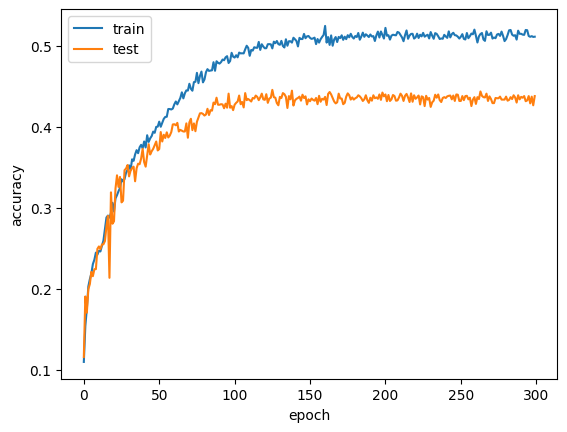

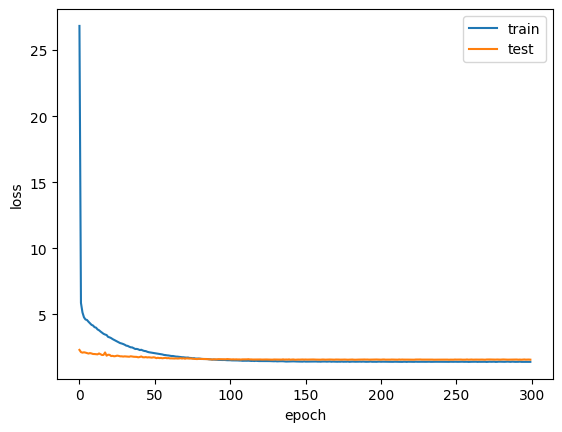

In [17]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [18]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_ReLU_ReLU1_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_trilinear_mixed_L1_L2.csv')

In [19]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.110000,0.116000,26.831345,2.294481
1,0.154143,0.190667,5.852442,2.129821
2,0.175571,0.170667,5.134256,2.087352
3,0.203143,0.199667,4.763432,2.114441
4,0.212000,0.206000,4.599107,2.090505


In [20]:
print(df["test_acc"].max())

0.44533333333333336


In [21]:
df.tail()

,train_acc,test_acc,train_loss,test_loss
295,0.511714,0.437667,1.400256,1.570221
296,0.510714,0.428667,1.398711,1.558442
297,0.511571,0.437000,1.396686,1.561153
298,0.510571,0.426333,1.394036,1.565171
299,0.510857,0.437667,1.390963,1.555814
